LogisticRegression Implementation from Scratch and Spam Classifier 
 - 
 


In [21]:
# Import Dependencies 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import KFold



In [ ]:
# LogisticRegression from Scratch 
class LogisticRegression():
    def __init__(self):
        self.train_losses = []
        self.val_losses =[]
        self.weights = None
  
        
    def fit(self,X_train,y_train, X_val, y_val,learningRate, numberOfEpochs):
        n_features = X_train.shape[1]
        weights = np.zeros(n_features)
        
        for epoch in range(numberOfEpochs):
            for i in range(len(X_train)):
                X_sample = X_train.iloc[i]
                y_sample = y_train.iloc[i]
                
                
                #Compute Gradient
                y_hat = 1/(1+np.exp(-np.dot(X_sample,weights)))
                gradient = (y_hat - y_sample) * X_sample
                weights-= learningRate*gradient
                self.weights = weights
                
            epsilon = 1e-10  # Small value to prevent log(0)
            y_train_pred = np.clip(1 / (1 + np.exp(-np.dot(X_train, weights))), epsilon, 1 - epsilon)
            train_loss = -np.mean(y_train * np.log(y_train_pred) + (1 - y_train) * np.log(1 - y_train_pred))
            self.train_losses.append(train_loss)

            y_val_pred = np.clip(1 / (1 + np.exp(-np.dot(X_val, weights))), epsilon, 1 - epsilon)
            val_loss = -np.mean(y_val * np.log(y_val_pred) + (1 - y_val) * np.log(1 - y_val_pred))
            self.val_losses.append(val_loss)
  
             
    def predict(self,X_test, prediction_classification = True):
        
        # Compute predicted probabilities
        predictions = 1 / (1 + np.exp(-np.dot(X_test, self.weights)))  # Sigmoid function
        if prediction_classification:
            
            # Convert probabilities to 0 or 1 using Numpy
            return (predictions >= 0.5).astype(int)
        else:
            return predictions
            
    
    def loss(self, y_pred, y_test, epsilon=1e-10):
        
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        # Binary Cross-Entropy Loss
        bce = -np.mean(y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
        return bce

    def plot_loss_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Curves(Best Model)')
        plt.legend()
        plt.grid(True)
        plt.show()

In [23]:
# Loading Data 
train_data = pd.read_csv("train_midterm.csv")
test_data = pd.read_csv("test_midterm.csv")

#Define X and y for trainning and validation 
X = train_data.drop("label", axis=1)
y = train_data["label"]

#Define  X and y for testing
x_test =test_data.drop("label", axis=1)
y_test = test_data["label"]



Testing LogisticRegression with learning rate:0.1  epouchs:50 
Trainning Loss:0.032424, Validation Loss:0.147229
_______________________________________________________________________________
Testing LogisticRegression with learning rate:0.1  epouchs:200 
Trainning Loss:0.017289, Validation Loss:0.184865
_______________________________________________________________________________
Testing LogisticRegression with learning rate:0.1  epouchs:500 
Trainning Loss:0.012865, Validation Loss:0.224547
_______________________________________________________________________________
Testing LogisticRegression with learning rate:0.01  epouchs:50 
Trainning Loss:0.099351, Validation Loss:0.151692
_______________________________________________________________________________
Testing LogisticRegression with learning rate:0.01  epouchs:200 
Trainning Loss:0.052015, Validation Loss:0.138902
_______________________________________________________________________________
Testing LogisticRegression wit

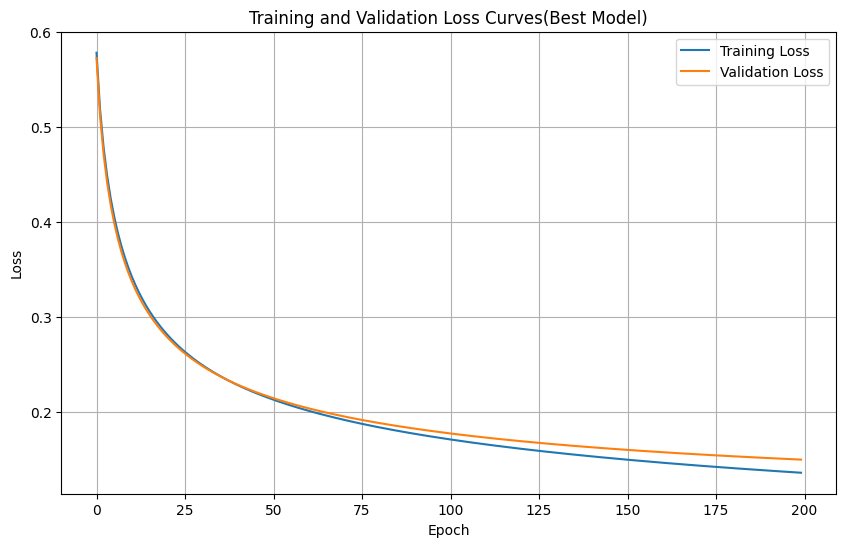

In [24]:
# Set up for Best Model
best_loss = float("inf") # Starting with very big value
best_params = None

# Set up  for  Hypertuning and Cross-Validation 
learning_rates =[0.1,0.01,0.001]
no_epouchs = [50,200,500]
kf = KFold(n_splits=5,shuffle=True,random_state=42)   # Shuffle data with fixed random order 


# Performing Cross-Validation
for learning_rate in learning_rates:
    for epoch in no_epouchs:
 
        val_loss_per_fold =[]
        train_loss_per_fold =[]
        print(f"Testing LogisticRegression with learning rate:{learning_rate}  epouchs:{epoch} ")
        for train_index, val_index in kf.split(X):
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_val = X.iloc[val_index]
            y_val = y.iloc[val_index]
            
            model = LogisticRegression() 
            
            # Train the model on the current fold
            model.fit(X_train, y_train, X_val, y_val, learning_rate, epoch)
           
            # Storing trainning and validation 
            val_loss_per_fold.append(model.val_losses[-1])
            train_loss_per_fold.append(model.train_losses[-1])
            
            mean_val_per_fold = np.mean(val_loss_per_fold)
            mean_train_per_fold = np.mean(train_loss_per_fold)
            
        # Store the best model
        gap = mean_val_per_fold -mean_train_per_fold
        threshold = 0.05
        if mean_val_per_fold <best_loss and gap <= threshold:
                best_loss =  mean_val_per_fold
                best_params = (learning_rate, epoch)
       
    
        print(f"Trainning Loss:{mean_train_per_fold:3f}, Validation Loss:{mean_val_per_fold:3f}")
        print("_______________________________________________________________________________")
       
       
# Best Model
print("              ***************************************       ")
print(f"Best model - Learning Rate: {best_params[0]}, Epochs: {best_params[1]}")

final_model = LogisticRegression()
final_model.fit(X,y,x_test,y_test,best_params[0],best_params[1])
        
# Metrics 
predictions = final_model.predict(x_test)
predictions_without_classification  =final_model.predict(x_test,False)
score = accuracy_score(y_test,predictions, normalize=True) *100
f_score =f1_score(y_test,predictions)
test_loss = final_model.loss(predictions_without_classification,y_test)
       
        
print(f"Training Loss:{final_model.train_losses[-1]:2f}, Validation Loss:{final_model.val_losses[-1]:f}")
print(f"Accuracy:{score:2f}, F1 Score:{f_score:2f}")
print(f"Test Loss:{test_loss:f}")
        
#Ploting best model
final_model.plot_loss_curve()
        
        
        